<a href="https://colab.research.google.com/github/rahulpatwal07/Tensorflow-course/blob/main/09_SkimLit__nlp_milestone_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Projects 2: SkimLit

The purpose of this notebook is to build a NLP model to make reading abstract easier.

We are replicating the this paper: https://arxiv.org/abs/1710.06071

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

## Get data

Since we'll be replicating the paper above (Pubmed 200k RCT), let's download the dataset they aree using


In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 20.08 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
# Check what files are in the PubMed-20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# We're gonna start our experiment with 20k records
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

In [ ]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename and returns the lines of text as a list

  Args:
    filename: a string containing the target filepath

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, 'r') as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(filenames[0])
train_lines[:20]

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n',
 "RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up .\n",
 'RE

In [ ]:
len(train_lines)

35135

Let's think about how we want our data to look...

```
[{'line_number': 0,
    'target': 'BACKGROUND',
    'text': (the paragraph),
    'total_lines': (no_of_lines)

},...

```

```

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number the target line is.
  """

  input_lines = get_lines(filename)
  abstract_lines = ''
  abstract_samples = []

  for line in input_lines:
    if line.startswith('###'): # check to see if this is an ID line
      abstract_id = line
      abstract_lines = '' # reset the abstract string if the line is an ID line
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate line
      # iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split('\t') # split target label from text
        line_data['target'] = target_text_split[0] # get target label
        line_data['text'] = target_text_split[1].lower() # get target text and lower it
        line_data['line_number'] = abstract_line_number # what number line does the line appear in the abstract?
        line_data['total_lines'] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    else:
      abstract_lines += line
  return abstract_samples


In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 651 ms, sys: 148 ms, total: 799 ms
Wall time: 1.3 s


In [ ]:
# Check the first abstract of our training data
train_samples[:11]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(11)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

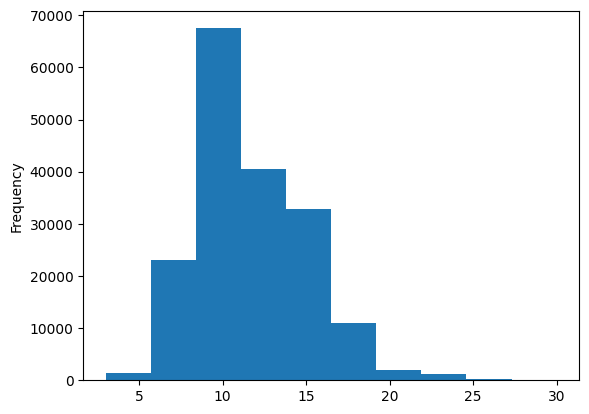

In [ ]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

### Get lists of sentences

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

## Make numeric labels (for ML model)


In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [ ]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0 - Getting a baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2024-06-14 13:25:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-06-14 13:25:07 (14.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                  y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data for deep sequence models

In [ ]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

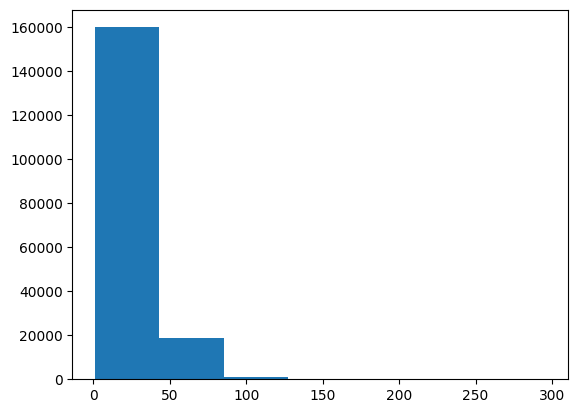

In [ ]:
plt.hist(sent_lens, bins=7);

In [ ]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

**Note** - It looks like 95% of the sentences in our training set have a length of 55 tokens or less.

When we create our tokenization layer, we'll use this value to turn all of our sentences into the same length. Meaning sentences with a length below 55 get padded with zeros and sentences with a length above 55 get truncated (words after 55 get cut off).

In [ ]:
max(sent_lens)

296

### Create text vectorizer

In [ ]:
#  How many words are in our vocabulary? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [ ]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

# Before TensorFlow 2.6
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55) # desired output length of vectorized sequences

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
results after treatment in the two groups , the obesity indices of w , a , bmi , f % and the blood lipid levels of tc , tg , ldl-c were obviously decreased compared with those before treatment ( all p < @ ) and the hdl-c levels were apparently increased than those before treatment ( both p < @ ) .

Length of text: 63

Vectorized text:
[[ 117   21   19    5    2   51   24    2  793 1555    4 2300    8  456
   769    3    2  107  864   93    4 2177 1692 1542    9 2457  212   34
     7  125  129   19   62   14    3    2 2784   93    9 3423   96   42
   125  129   19   54   14    0    0    0    0    0    0    0    0]]


In [ ]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create a text embedding

In [ ]:
from tensorflow.keras import layers
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding")

# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
results after treatment in the two groups , the obesity indices of w , a , bmi , f % and the blood lipid levels of tc , tg , ldl-c were obviously decreased compared with those before treatment ( all p < @ ) and the hdl-c levels were apparently increased than those before treatment ( both p < @ ) .

Sentence after vectorization (before embedding):
[[ 117   21   19    5    2   51   24    2  793 1555    4 2300    8  456
   769    3    2  107  864   93    4 2177 1692 1542    9 2457  212   34
     7  125  129   19   62   14    3    2 2784   93    9 3423   96   42
   125  129   19   54   14    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[-0.04385351 -0.03198819  0.01551641 ... -0.02414212 -0.00070597
   -0.04215307]
  [ 0.01633808 -0.02800572 -0.03477921 ...  0.00704349 -0.04455646
    0.03026254]
  [-0.02257298 -0.00154459  0.01574915 ...  0.00433302 -0.04396634
    0.01512375]
  ...
  [-0.04498435  0.00590543  0.00140526 ... -0.0100869

### Creating datasets

We're gonna use tf.data API to make sure our data loads as fast as possible -  
* https://www.tensorflow.org/guide/data_performance

* https://www.tensorflow.org/guide/data

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [ ]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1 : Conv1D with token embedding

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(filters=64, kernel_size=5, padding="same", activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [ ]:
model_1.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
# Fit the model
history_1 = model_1.fit(train_dataset,
                        steps_per_epoch=int(0.1 * len(train_dataset)),
                        epochs=3,
                        validation_data = valid_dataset,
                        validation_steps=len(valid_dataset),
                        callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3))

Epoch 1/3
562/562 [==============================] - 23s 36ms/step - loss: 0.9179 - accuracy: 0.6370 - val_loss: 0.6865 - val_accuracy: 0.7417
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.6534 - accuracy: 0.7588 - val_loss: 0.6352 - val_accuracy: 0.7722
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.6147 - accuracy: 0.7757 - val_loss: 0.5984 - val_accuracy: 0.7853


In [ ]:
# Evaluate on whole dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5984 - accuracy: 0.7853


[0.5984448194503784, 0.785317063331604]

In [ ]:
# Make predictions
model_1_pred_probs = model_1.predict(test_dataset)

942/942 [==============================] - 2s 2ms/step


In [ ]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 4, 4, 0, 1, 0])>

In [ ]:
model_1_results = calculate_results(test_labels_encoded, model_1_preds)
model_1_results

{'accuracy': 78.1251037000166,
 'precision': 0.7789668786699486,
 'recall': 0.781251037000166,
 'f1': 0.7791462973808027}

## Model 2 - Feature Extraction with pretrained token embeddings

Now lets use pretrained word embeddings from Tensorflow Hub (kaggle).

In [ ]:
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2",
                      trainable=False,
                       name='universal_sentence_encoder')


In [ ]:
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")

Random training sentence:
@ children were enrolled of whom @ % were nave to art ; @ ( @ % ) were hiv negative .

Sentence after embedding:
[-0.04339875  0.065777    0.06626906 -0.00830453 -0.08774126  0.04489712
  0.06438059  0.04964789 -0.08034504 -0.03347429  0.05780061 -0.02014776
  0.0607979   0.05993378  0.07783078 -0.01078463 -0.09040571 -0.0542316
 -0.03800168 -0.06460469  0.01889847  0.01185467 -0.04818166 -0.00229898
  0.01352156 -0.01713178 -0.03432157  0.04829683  0.06129245  0.06053852]



### Building and fitting an NLP feature extraction model using pretrained embeddings

In [ ]:
inputs = layers.Input(shape=[], dtype=tf.string)
x = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs)

model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
model_2.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
# Fit the model
history_2 = model_2.fit(train_dataset,
                        steps_per_epoch=int(0.1 * len(train_dataset)),
                        epochs=3,
                        validation_data = valid_dataset,
                        validation_steps=int(0.1*len(valid_dataset)),
                        callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3))

Epoch 1/3
562/562 [==============================] - 10s 14ms/step - loss: 0.9191 - accuracy: 0.6495 - val_loss: 0.7962 - val_accuracy: 0.6925
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7676 - accuracy: 0.7025 - val_loss: 0.7528 - val_accuracy: 0.7091
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7493 - accuracy: 0.7140 - val_loss: 0.7357 - val_accuracy: 0.7168


In [ ]:
# Evaluate on whole dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7386 - accuracy: 0.7153


[0.7386394739151001, 0.7153118252754211]

In [ ]:
# Make predictions
model_2_pred_probs = model_2.predict(test_dataset)

942/942 [==============================] - 9s 9ms/step


In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 2, 4, 4, 2, 0, 4, 1])>

In [ ]:
model_2_results = calculate_results(test_labels_encoded, model_2_preds)
model_2_results

{'accuracy': 70.90094574415133,
 'precision': 0.7110665608806374,
 'recall': 0.7090094574415132,
 'f1': 0.7061723242705957}

## Model 3 - Conv1D with character embedding

The paper we're replicating (PubMed 200k RCT) used a combination of token an character-level embedding


### Creating a character-level tokenizer

In [ ]:
# Make fucntions to split sentences into characters
def split_chars(text):
  return ' '.join(list(text))

In [ ]:
# Split sequence-level data splis into character-level daa splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [ ]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

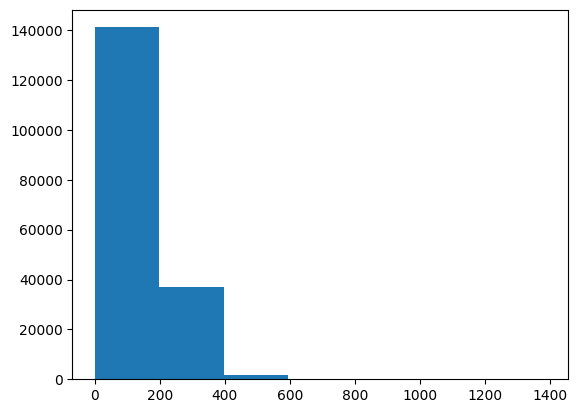

In [ ]:
# Check the distribution of our sequence at the character-level
plt.hist(char_lens, bins=7)

In [ ]:
# Find what character length conver 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=55,
                                    standardize='lower_and_strip_punctuation',
                                    name='char_vectorizer')

In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 p r o s p e c t i v e   m u l t i c e n t r i c   r a n d o m i z e d   d o u b l e - b l i n d   s t u d y   .

Length of random_train_chars: 51

Vectorized chars:
[[14  8  7  9 14  2 11  3  4 21  2 15 16 12  3  4 11  2  6  3  8  4 11  8
   5  6 10  7 15  4 25  2 10 10  7 16 22 12  2 22 12  4  6 10  9  3 16 10
  19  0  0  0  0  0  0]]

Length of vectorized chars: 55


### Creating a character level embedding

In [ ]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                               output_dim=25,
                               mask_zero=True,
                               name='char_embed')

In [ ]:
print(f"Charified textL \n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified textL 
 p r o s p e c t i v e   m u l t i c e n t r i c   r a n d o m i z e d   d o u b l e - b l i n d   s t u d y   .

Embedded chars (after vectorization and embedding):
 [[[-0.03738431  0.04603943 -0.01875783 ... -0.0142395   0.01822729
    0.01571709]
  [ 0.02428672 -0.00151924 -0.00782191 ...  0.0306848  -0.00594459
    0.03190671]
  [ 0.00200174  0.02804191 -0.033774   ... -0.03101057 -0.01611427
   -0.04735756]
  ...
  [ 0.00246661 -0.00231562 -0.039025   ...  0.04265051  0.04675088
   -0.01338512]
  [ 0.00246661 -0.00231562 -0.039025   ...  0.04265051  0.04675088
   -0.01338512]
  [ 0.00246661 -0.00231562 -0.039025   ...  0.04265051  0.04675088
   -0.01338512]]]

Character embedding shape: (1, 55, 25)


In [ ]:
len(random_train_chars)

111

### Building a Conv1D model to fit on character embeddings

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)

char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)

x = layers.Conv1D(filters=128, kernel_size=5, padding='same', activation='relu')(char_embeddings)

x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_3 = tf.keras.Model(inputs, outputs, name='model_3_conv1d_char_embeddings')

model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 55)                0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 55, 25)            700       
                                                                 
 conv1d_1 (Conv1D)           (None, 55, 128)           16128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 

In [ ]:
# Compile the model
model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Fit the model
history_3 = model_3.fit(train_char_dataset,
                        steps_per_epoch=int(0.1 * len(train_char_dataset)),
                        epochs=3,
                        validation_data = valid_char_dataset,
                        validation_steps=int(0.1*len(valid_char_dataset)),
                        callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3))

Epoch 1/3
562/562 [==============================] - 5s 6ms/step - loss: 1.2688 - accuracy: 0.4773 - val_loss: 1.0886 - val_accuracy: 0.5615
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 1.0505 - accuracy: 0.5830 - val_loss: 0.9914 - val_accuracy: 0.6094
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9714 - accuracy: 0.6183 - val_loss: 0.9314 - val_accuracy: 0.6406


In [ ]:
model_3_pred_probs = model_3.predict(valid_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds[:5]

945/945 [==============================] - 2s 3ms/step


<tf.Tensor: shape=(5,), dtype=int64, numpy=array([2, 1, 3, 2, 2])>

In [ ]:
model_3_results = calculate_results(val_labels_encoded, model_3_preds)
model_3_results

{'accuracy': 63.18681318681318,
 'precision': 0.6332218558143232,
 'recall': 0.6318681318681318,
 'f1': 0.6210644994155026}

## Model 4 - Combining pretrained token embeddings + character embeddings

1. Create a token level embedding model
2. Create a character-level model
3. Combine 1 and 2 with a concatenate
4. Build a series of output layers on top of 3.
5. Construct a model which takes and character-level sequences as input and produces sequence label probabilities as output.

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype='string')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)

char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 55)                   0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

In [ ]:
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

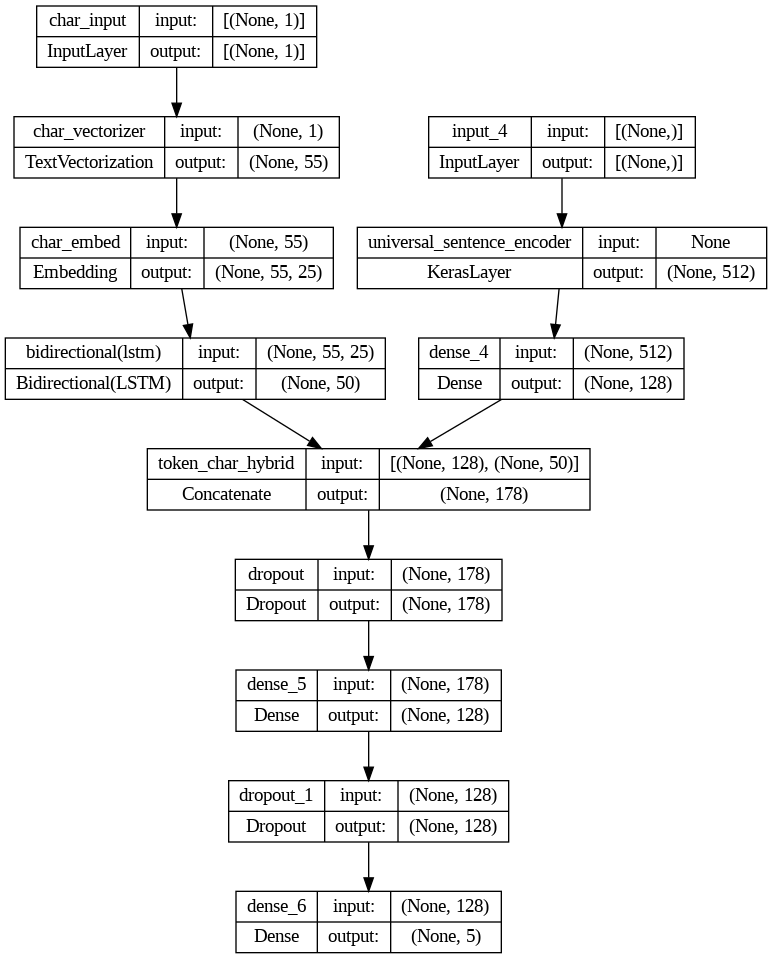

In [ ]:
# Plot hyibrid token and character  model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

### Combining token and character data into a tf.data Dataset


In [ ]:
# Combine the char and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Fitting a model on token and character-level sequences

In [ ]:
# Fit the model on tokens and chars
history_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 31s 34ms/step - loss: 0.9887 - accuracy: 0.6016 - val_loss: 0.7893 - val_accuracy: 0.6932
Epoch 2/3
562/562 [==============================] - 15s 27ms/step - loss: 0.8084 - accuracy: 0.6886 - val_loss: 0.7258 - val_accuracy: 0.7197
Epoch 3/3
562/562 [==============================] - 15s 27ms/step - loss: 0.7767 - accuracy: 0.7018 - val_loss: 0.6971 - val_accuracy: 0.7337


In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 15s 15ms/step - loss: 0.7018 - accuracy: 0.7306


[0.7018128037452698, 0.7306037545204163]

In [ ]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds[:5]

945/945 [==============================] - 16s 14ms/step


<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 1, 3, 2, 2])>

In [ ]:
# get results of token_char-hybrid model
model_4_results = calculate_results(val_labels_encoded, model_4_preds)
model_4_results

{'accuracy': 73.06037336157817,
 'precision': 0.7317824244967462,
 'recall': 0.7306037336157818,
 'f1': 0.7271293873826236}

## Model 5 - Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


**Note** - Note: Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

### Create positional embeddings

In [ ]:
train_df['line_number'].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

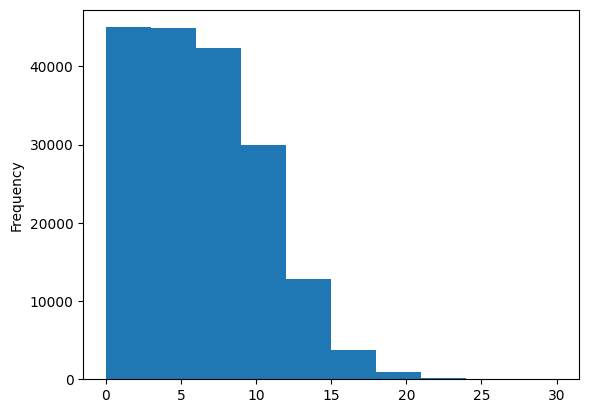

In [ ]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:14], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

In [ ]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

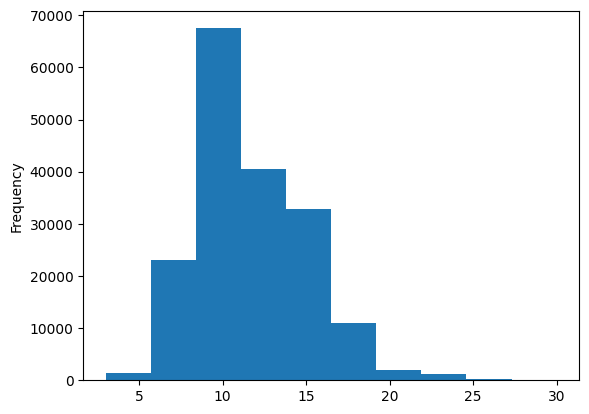

In [ ]:
# Check the distribution of "total_lines" column
train_df.total_lines.plot.hist()

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Building a tribrid embedding model
1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of into a tf.keras.Model

In [ ]:
# 1. Create a token-level model
token_inputs = layers.Input(shape=[], dtype='string', name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Create a character-level model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Create a model for the "line_number" feature
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name='line_number_input')
x = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

# 4. Create a model for the "total_lines" feature
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

# 5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

# 7. Create an output layer to accept the tribrid embedding
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Combine the inputs of 1, 2, 3, 4 and outputs of into a tf.keras.Model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="model_5_tribrid_embedding_model")

In [ ]:
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 55)                   0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   

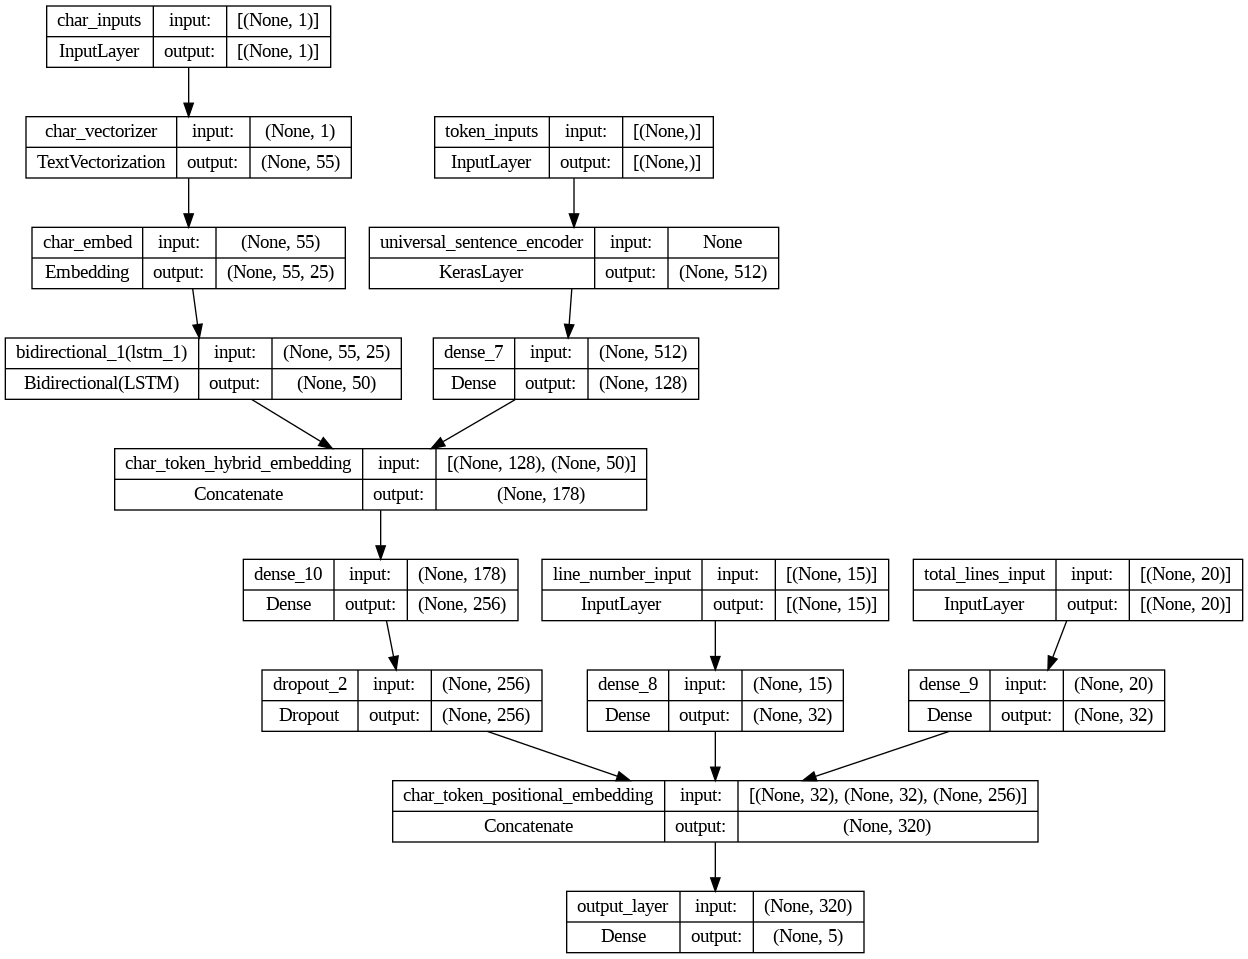

In [ ]:
# Plot model_5 to explore it visually...
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
# Create training and valiadation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
history_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 30s 35ms/step - loss: 1.1026 - accuracy: 0.7137 - val_loss: 0.9850 - val_accuracy: 0.8055
Epoch 2/3
562/562 [==============================] - 17s 31ms/step - loss: 0.9685 - accuracy: 0.8154 - val_loss: 0.9488 - val_accuracy: 0.8245
Epoch 3/3
562/562 [==============================] - 17s 30ms/step - loss: 0.9514 - accuracy: 0.8223 - val_loss: 0.9390 - val_accuracy: 0.8314


In [ ]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

945/945 [==============================] - 17s 15ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.0266119422746,
 'precision': 0.8289549160513642,
 'recall': 0.830266119422746,
 'f1': 0.8292962762022251}

## Compare results

In [ ]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.125104,0.778967,0.781251,0.779146
model_2_pretrained_token_embedding,70.900946,0.711067,0.709009,0.706172
model_3_custom_char_embedding,63.186813,0.633222,0.631868,0.621064
model_4_hybrid_char_token_embedding,73.060373,0.731782,0.730604,0.727129
model_5_pos_char_token_embedding,83.026612,0.828955,0.830266,0.829296


In [ ]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

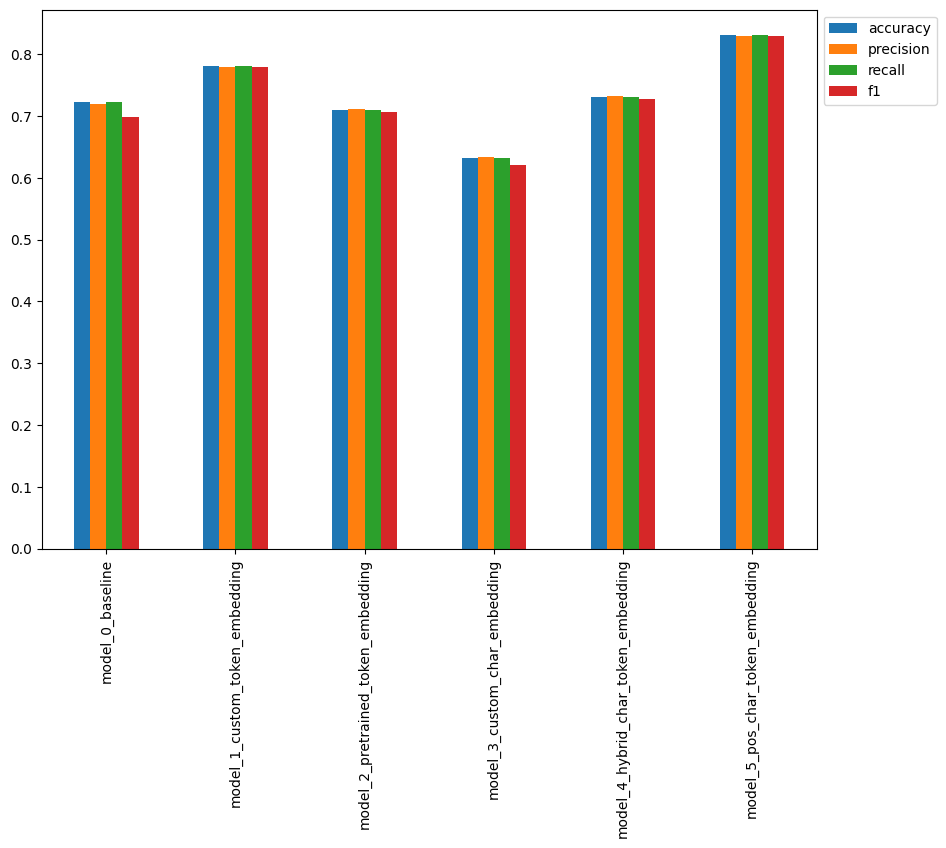

In [ ]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

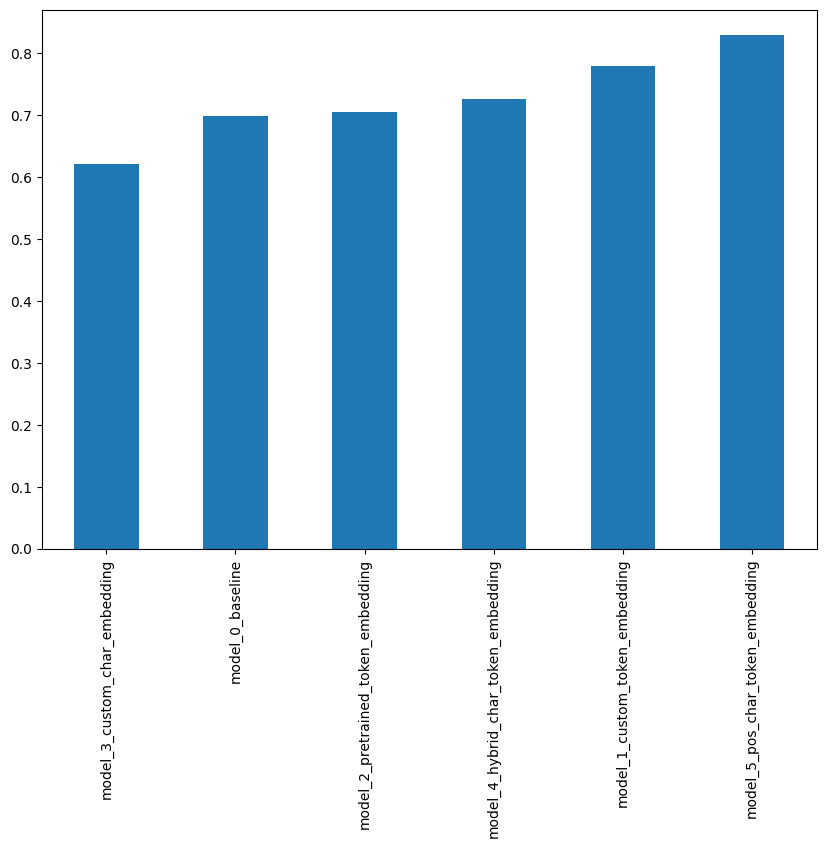

In [ ]:
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10, 7));
